In [40]:
## Import lib for extracting training set from pdfs
import extract
import importlib
importlib.reload(extract)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy import optimize

In [41]:
#  Extract training set
train_indicies = extract.extract_words()

In [42]:
# Read training files as one string
smr_content = open('sum_train.txt', 'r').read()
xprnc_content = open('exp_train.txt', 'r').read()
edct_content = open('edu_train.txt', 'r').read()

In [43]:
# take a segment name (s_tern) and a string of the whole segment content and split the content for different CVs
def string_list(s_term, s_str):
    result = []
    crnt_ptr = s_str.find(s_term) + len(s_term)
    scd_term_index=s_str.find(s_term, crnt_ptr)
    while (scd_term_index>=0):
        # count only significantly long segments (>9 characters)
        if (scd_term_index-crnt_ptr>9):
            result.append(s_term + ' ' + s_str[crnt_ptr:scd_term_index])
        crnt_ptr = scd_term_index + len(s_term)
        scd_term_index=s_str.find(s_term, crnt_ptr)
    return result

In [44]:
# Put segment from each CV into separate string in an array
sum_list = string_list("Summary", smr_content)
xprnc_list = string_list("Experience", xprnc_content)
edctn_list = string_list("Education", edct_content)

In [45]:
# Function for extracting vocabulary specific for a segment
import re
from nltk.stem.snowball import SnowballStemmer
def create_dictionary(topic_list):
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    result = dict()
    stemmer = SnowballStemmer('english')
    for string in topic_list:
        # split a certain CV part into words and filter blanks out
        a = re.split('[^0-9A-Za-z]', string)
        a=list(filter(lambda x: x!='', a))
        for i in range(len(a)):
            a[i] = a[i].casefold()
            if re.fullmatch(year_expr, a[i]):
                a[i] = '!year'
            elif re.fullmatch(month_expr, a[i]):
                a[i] = '!month'
            else:
                a[i] = stemmer.stem(a[i])
            if (a[i] in result):
                result[a[i]] += 1
            else:
                result[a[i]] = 1
                
    return result

def create_dct_from_string(string):
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    result = dict()
    stemmer = SnowballStemmer('english')
    
    # split a certain CV part into words and filter blanks out
    a = re.split('[^0-9A-Za-z]', string)
    a=list(filter(lambda x: x!='', a))
    for i in range(len(a)):
        a[i] = a[i].casefold()
        if re.fullmatch(year_expr, a[i]):
            a[i] = '!year'
        elif re.fullmatch(month_expr, a[i]):
            a[i] = '!month'
        else:
            a[i] = stemmer.stem(a[i])
        if (a[i] in result):
            result[a[i]] += 1
        else:
            result[a[i]] = 1
                
    return result


In [46]:
# Extract vocabulary specific for a segment
sum_dct = create_dictionary(sum_list)
xprnc_dct = create_dictionary(xprnc_list)
edctn_dct = create_dictionary(edctn_list)

In [47]:
# Functions for calculating term frequencies and corpus dictionary creation
def concat_dct(d1, d2):
    d3 = dict(d1)
    for key in d2.keys():
        if (key in d3):
            d3[key] += d2[key]
        else:
            d3[key] = d2[key]
    return d3

def sumDictValues(dctnr):
    N = 0
    for val in dctnr.values():
        N = N + val
    return N

def calc_probs(dctnr):
    prob_dctnr = dict()
    tot_size = sumDictValues(dctnr)
    for key in dctnr.keys():
        prob_dctnr[key] = dctnr[key]/tot_size
    return prob_dctnr

In [50]:
# Uniting into corpus dictionary
new_dict = concat_dct(xprnc_dct, edctn_dct)
whole_dict = concat_dct(new_dict, sum_dct)

In [51]:
# Calculating probabilities
sum_prb = calc_probs(sum_dct)
xprnc_prb = calc_probs(xprnc_dct)
edctn_prb = calc_probs(edctn_dct)
whole_dict_prb = calc_probs(whole_dict)

In [52]:
# Test data generation
smr_test_content = open('sum_test.txt', 'r').read()
exp_test_content = open('exp_test.txt', 'r').read()
edu_test_content = open('edu_test.txt', 'r').read()

In [53]:
def replace_with_space(matchobj):
    return " "

def construct_marked_set(new_content):
    CRIT_LENGTH_LIMIT = 100
    result = np.zeros(4).reshape(1,4)
#    rep_pattern = re.compile(r"((Summary|Experience|Education)|[^A-Za-z0-9\s])")
    rep_pattern = re.compile(r"([^A-Za-z0-9\s])")
    category = 1
    for string in new_content:
        a = re.sub(rep_pattern, replace_with_space, string)
        cumulative_str = ''
        for substr in a.split('\n'):
            cumulative_str += substr + ' '
            if(len(cumulative_str) > CRIT_LENGTH_LIMIT):
                result = np.append(result, np.asarray([cumulative_str, category, 0, -300000.0]).reshape(1,4), axis=0)
                cumulative_str = ''
        if(len(cumulative_str) > 2):
                result = np.append(result, np.asarray([cumulative_str, category, 0, -300000.0]).reshape(1,4), axis=0)
        category += 1
    return result[1:]

def construct_marked_set_KL(new_content):
    CRIT_LENGTH_LIMIT = 100
    result = np.zeros(4).reshape(1,4)
#    rep_pattern = re.compile(r"((Summary|Experience|Education)|[^A-Za-z0-9\s])")
    rep_pattern = re.compile(r"([^A-Za-z0-9\s])")
    category = 1
    for string in new_content:
        a = re.sub(rep_pattern, replace_with_space, string)
        cumulative_str = ''
        for substr in a.split('\n'):
            cumulative_str += substr + ' '
            if(len(cumulative_str) > CRIT_LENGTH_LIMIT):
                str_cnt_dct = create_dct_from_string(cumulative_str)
                str_prb_dict = calc_probs(str_cnt_dct)
                result = np.append(result, np.asarray([str_prb_dict, category, 0, m.inf]).reshape(1,4), axis=0)
                cumulative_str = ''
        if(len(cumulative_str) > 2):
                str_cnt_dct = create_dct_from_string(cumulative_str)
                str_prb_dict = calc_probs(str_cnt_dct)
                result = np.append(result, np.asarray([str_prb_dict, category, 0, m.inf]).reshape(1,4), axis=0)
        category += 1
    return result[1:]

In [54]:
test_set = construct_marked_set([smr_test_content, edu_test_content, exp_test_content])
test_set_KL = construct_marked_set_KL([smr_test_content, edu_test_content, exp_test_content])

In [55]:
# precision, recall, F1-score
def quality_assessment(a, b, ctgr):
    b_correct = ((a.astype(int) == b.astype(int)) * a.astype(int)==ctgr).sum()
    b_attempts = ((b.astype(int) == ctgr)).sum()
    a_total = ((a.astype(int) == ctgr)).sum()
    if b_attempts == 0:
        return 0, 0, 0
    prec = b_correct/b_attempts
    rcll = b_correct/a_total
    f_one = 2*prec*rcll/(prec+rcll)
#    print ('precision = %f' %prec)
#    print ('recall =', rcll)
#    print ('F1-score =', f_one)
    return prec, rcll, f_one

In [56]:
import math as m
from nltk.stem.snowball import SnowballStemmer
def calculate_ML(string, dct, corp_dct, prb_segment):
    stemmer = SnowballStemmer('english')
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    num = 1.0
    den = 1.0
    result = .0
    for word in string.split():
        wrd = word.casefold()
        if re.fullmatch(year_expr, wrd):
            wrd = '!year'
        elif re.fullmatch(month_expr, wrd):
            wrd = '!month'
        else:
             wrd = stemmer.stem(wrd)
        #print(wrd)
        if wrd in dct:# and wrd in corp_dct:
            num *= dct[wrd]
            den *= corp_dct[wrd]
            result += m.log2(prb_segment*num/den)
        else:
            result += m.log2(1e-300)
    #print(num)
    #print(den)
    return result

def calculate_KL_risk(query_model, doc_model):
    result = 0
    for key in query_model.keys():
        log_ = 0
        if key in doc_model:
            log_ = m.log2(query_model[key]/doc_model[key])
        else:
            log_ = m.log2(1e+300)
        result += query_model[key]*log_
    return result
    
def test_algorithm(test_set, dictionaries, corpus_dict):
    local_test_set = test_set.copy()
    #likelihoods = np.zeros(len(dictionaries))
    prb_corpus = calc_probs(corpus_dict)
    i=0
    for a_dict in dictionaries:
        prb_segment = sumDictValues(a_dict) / sumDictValues(corpus_dict)
        print('Segment ' + repr(i+1) + ' portion in the dictionary ' + repr(prb_segment))
        prb_dict = calc_probs(a_dict)
        for line in local_test_set:
#                print('new_like')
#                print(line[0] + "ttteeest")
            likelihood = calculate_ML(line[0], prb_dict, prb_corpus, prb_segment)
            if likelihood > np.float(line[3]):
                line[3] = likelihood
                line[2] = i+1
        i+=1
#    prc, recall, f_one_score = quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)
    F1_score_array = np.array([])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 1)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 2)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)[2])
    f_one_score = np.mean(F1_score_array)
    return f_one_score, local_test_set

def test_algorithm_w_KL(test_set_KL, dictionaries):
    local_test_set = test_set_KL.copy()
    #likelihoods = np.zeros(len(dictionaries))
    i=0
    for a_dict in dictionaries:
        prb_dict = calc_probs(a_dict)
        for line in local_test_set:
            risk = calculate_KL_risk(line[0], prb_dict)
            if risk < np.float(abs(line[3])):
                line[3] = risk
                line[2] = i+1
        i+=1
    F1_score_array = np.array([])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 1)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 2)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)[2])
    f_one_score = np.mean(F1_score_array)
    return f_one_score, local_test_set

In [57]:
calculate_KL_risk(test_set_KL[0,0], sum_prb)

271.04011196947175

In [58]:
calculate_KL_risk(test_set_KL[0,0], xprnc_prb)

157.4111063458181

In [59]:
calculate_KL_risk(test_set_KL[0,0], edctn_prb)

652.8204350029671

In [60]:
f1_score, result_test_set_ML = test_algorithm(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)
print(f1_score)

Segment 1 portion in the dictionary 0.1674347158218126
Segment 2 portion in the dictionary 0.1455879842976617
Segment 3 portion in the dictionary 0.6869772998805257
0.666099257312


In [61]:
f1_score, result_test_set_KL = test_algorithm_w_KL(test_set_KL, [sum_dct, edctn_dct, xprnc_dct])
print(f1_score)

0.67010771449


In [62]:
result_test_set_ML[:15,1:]

array([['1', '3', '-4075.036620161563'],
       ['1', '3', '-6973.657129319131'],
       ['1', '3', '-2987.1072239231726'],
       ['1', '1', '-5768.094775741681'],
       ['1', '3', '-1985.7431576726995'],
       ['1', '3', '-5975.386188162497'],
       ['1', '3', '-983.6343162679353'],
       ['1', '3', '-3976.928955386668'],
       ['1', '1', '-4668.526760093729'],
       ['1', '3', '-4105.109597297142'],
       ['1', '1', '-3871.722754628121'],
       ['1', '1', '-1822.9117889268123'],
       ['1', '1', '-6967.978296766264'],
       ['1', '1', '-10932.356081109712'],
       ['1', '3', '-8001.081281184769']], 
      dtype='<U209')

In [63]:
result_test_set_KL[:15,1:]

array([[1, 3, 157.4111063458181],
       [1, 3, 252.41005864424997],
       [1, 3, 146.5480784404526],
       [1, 1, 241.7914282715897],
       [1, 1, 121.56307973557337],
       [1, 3, 377.83431743390906],
       [1, 3, 51.7160418499387],
       [1, 3, 238.8440002313848],
       [1, 1, 154.33595346756894],
       [1, 3, 193.54874174220168],
       [1, 1, 184.65024385945318],
       [1, 1, 114.82562927314541],
       [1, 1, 389.981785147974],
       [1, 1, 578.6081308142208],
       [1, 3, 472.41410186260623]], dtype=object)

In [109]:
(result_test_set_KL[:,2] == 2).sum()

34

In [110]:
np.where(result_test_set_KL[:,2] == 2)

(array([41, 42, 44, 45, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
        61, 63, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 82, 91]),)

In [17]:
print(confusion_matrix(result_test_set[:,1], result_test_set[:,2]))

[[15  2 27]
 [ 0 30  6]
 [ 3  2 98]]


# Probability smoothing

In [18]:
def jelin_merc_smoothing(segm_dict, corpus_dict, lmbd):
    result_dct = dict()
    prb_dict = calc_probs(segm_dict)
    for key in corpus_dict.keys():
        if key in segm_dict:
            result_dct[key] = (1-lmbd)*prb_dict[key] + lmbd*corpus_dict[key]
        else:
            result_dct[key] = lmbd*corpus_dict[key]
    return result_dct

def dirichlet_smoothing(segm_dict, corpus_dict, mu):
    result_dct = dict()
    #d = len(segm_dict.keys())
    d = sumDictValues(segm_dict)
    for key in corpus_dict.keys():
        if key in segm_dict:
            result_dct[key] = segm_dict[key]/(d+mu) + mu/(d+mu)*corpus_dict[key]
        else:
            result_dct[key] = mu/(d+mu)*corpus_dict[key]
    return result_dct

In [19]:
def test_algorithm_w_smoothing(test_set, dictionaries, corpus_dict, smoothing_method, param):
    #likelihoods = np.zeros(len(dictionaries))
    local_test_set = test_set.copy()
    prb_corpus = calc_probs(corpus_dict)
    i=0
    for a_dict in dictionaries:
        prb_segment = sumDictValues(a_dict) / sumDictValues(corpus_dict)
        prb_smoothed = smoothing_method(a_dict, prb_corpus, param)
        for line in local_test_set:
            likelihood = calculate_ML(line[0], prb_smoothed, prb_corpus, prb_segment)
            if likelihood > np.float(line[3]):
                line[3] = likelihood
                line[2] = i+1
        i+=1
    F1_score_array = np.array([])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 1)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 2)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)[2])
    f_one_score = np.mean(F1_score_array)
    return f_one_score

In [20]:
def analyze_lmbd(test_set, dictionaries, corpus_dict):
    lmbd_arr = np.linspace(0,1,10)
    lmbd_arr[0] = 1e-10
    f_score_arr = np.zeros(lmbd_arr.size)
    for i in range(len(lmbd_arr)):
        f_score_arr[i] = test_algorithm_w_smoothing(test_set, dictionaries, corpus_dict, jelin_merc_smoothing, lmbd_arr[i])
    print('F1-score array: {}'.format(f_score_arr))
    print('Max F-score={} at lambda = {}'.format(np.max(f_score_arr), lmbd_arr[np.argmax(f_score_arr)]))
    return lmbd_arr, f_score_arr

F1-score array: [ 0.69528925  0.76007326  0.75318532  0.76180011  0.76180011  0.75681744
  0.76568665  0.72086629  0.59744921  0.24009324]
Max F-score=0.7656866545968727 at lambda = 0.6666666666666666


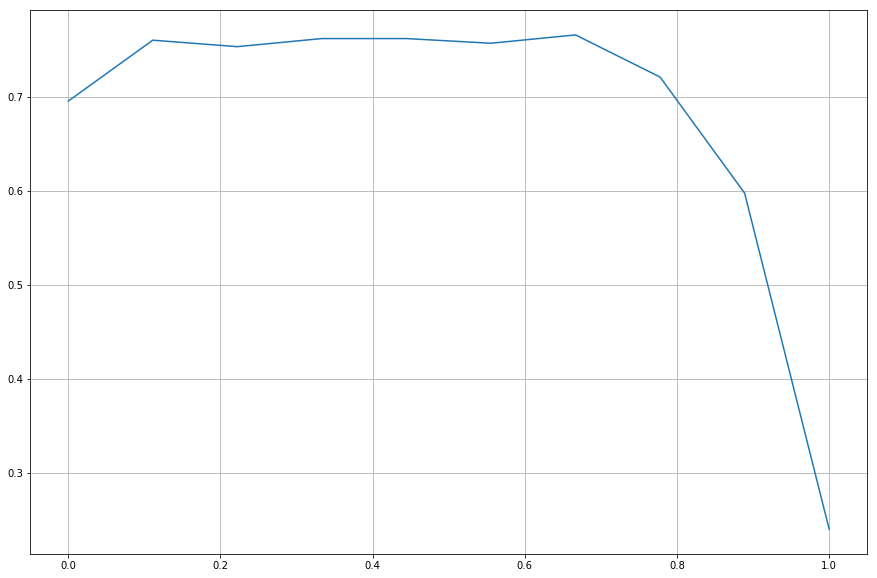

In [21]:
lambdas, f_scores = analyze_lmbd(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

fig = plt.figure(figsize=[15,10])
plt.plot(lambdas, f_scores)
plt.grid()
plt.show()

In [22]:
def analyze_mu(test_set, dictionaries, corpus_dict):
    mu_arr = np.geomspace(.1,100000,num=100)
    f_score_arr = np.zeros(mu_arr.size)
    for i in range(len(mu_arr)):
        f_score_arr[i] = test_algorithm_w_smoothing(test_set, dictionaries, corpus_dict, dirichlet_smoothing, mu_arr[i])
    print('F1-score array: {}'.format(f_score_arr))
    print('Max F-score={} at u={}'.format(np.max(f_score_arr), mu_arr[np.argmax(f_score_arr)]))
    return mu_arr, f_score_arr

F1-score array: [ 0.72045834  0.7331628   0.7331628   0.7331628   0.7331628   0.7331628
  0.7331628   0.74921818  0.74921818  0.74921818  0.75884102  0.75884102
  0.75884102  0.75884102  0.75455315  0.75455315  0.75455315  0.75455315
  0.76061104  0.76061104  0.76061104  0.76655348  0.76655348  0.77585054
  0.77585054  0.77585054  0.77585054  0.77585054  0.78490821  0.78490821
  0.78490821  0.78490821  0.78490821  0.78490821  0.78490821  0.78490821
  0.78490821  0.78490821  0.77914202  0.77914202  0.77914202  0.77914202
  0.78797036  0.78797036  0.78797036  0.78528228  0.78528228  0.78528228
  0.77644231  0.77644231  0.78080178  0.78935639  0.78935639  0.78376129
  0.78376129  0.77926528  0.77926528  0.77926528  0.77483412  0.78306014
  0.76798942  0.76562077  0.76562077  0.76023967  0.78427547  0.77895876
  0.77895876  0.77895876  0.78353964  0.77830688  0.77313798  0.77313798
  0.77041713  0.77830688  0.77830688  0.77502246  0.77502246  0.76690092
  0.77151234  0.76314111  0.76775693

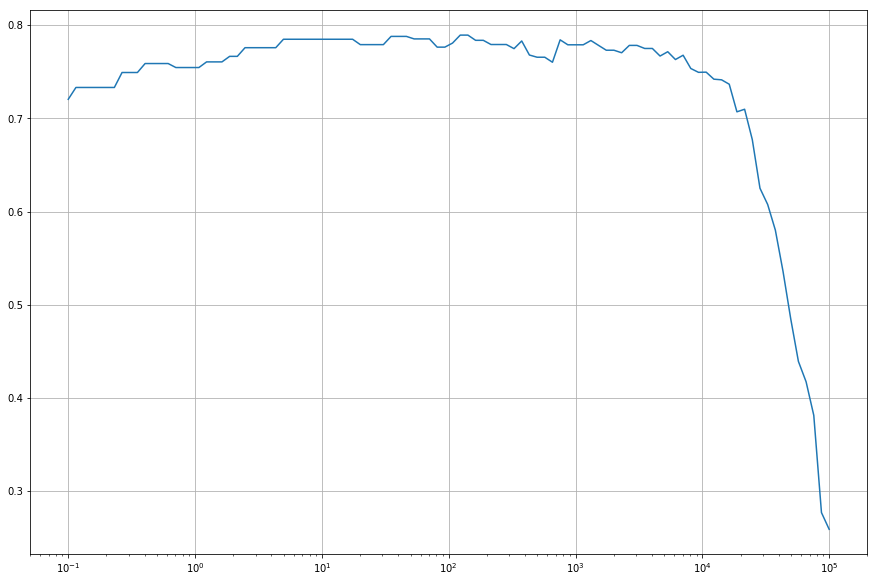

In [23]:
mus, f_scores = analyze_mu(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

fig = plt.figure(figsize=[15,10])
plt.semilogx()
plt.plot(mus, f_scores)
plt.grid()
plt.show()

In [24]:
def loo_smoothing(segm_cnt_dict, corpus_prb_dict, mu):
    result_dct = dict()
    #d = len(segm_dict.keys())
    d = sumDictValues(segm_cnt_dict) - 1
    for key in corpus_prb_dict.keys():
        if key in segm_cnt_dict:
            result_dct[key] = segm_cnt_dict[key]*np.log2((segm_cnt_dict[key] - 1 + mu*corpus_prb_dict[key])/(d-1+mu))
        else:
            result_dct[key] = 0
    return result_dct

In [25]:
def profit_function(u_param, doc_cnt_dcts, corp_prb_dct):
    profit = 0
    for dct in doc_cnt_dcts:
#         print(len(loo_smoothing(dct, corp_prb_dct, u_param)))
        profit += sumDictValues(loo_smoothing(dct, corp_prb_dct, u_param))
    return -profit
    

print(profit_function(55000, [sum_dct, edctn_dct, xprnc_dct], whole_dict_prb))

pfvec = np.vectorize(profit_function, excluded=[1,2])

171916.903012


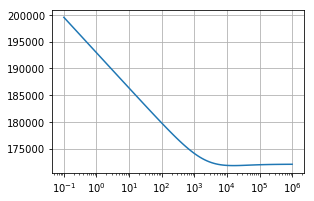

In [26]:
mu_ary = np.geomspace(.1, 1000000, num=100)
prf_ary = pfvec(mu_ary, [sum_dct, edctn_dct, xprnc_dct], whole_dict_prb)
fig, ax = plt.subplots(figsize=[4.5,3])
plt.semilogx()
plt.plot(mu_ary, prf_ary)
plt.grid()
plt.show()

In [27]:
init_mu = np.zeros(1)+1e-30
mu_cnvg = optimize.minimize(profit_function, init_mu, args=([sum_dct, edctn_dct, xprnc_dct], whole_dict_prb), method='Nelder-Mead', options={'maxiter':5000}, tol=1e-30)

In [28]:
print(mu_cnvg)

 final_simplex: (array([[ 15872.44329757],
       [ 15872.44329757]]), array([ 171816.36760442,  171816.36760442]))
           fun: 171816.36760441668
       message: 'Optimization terminated successfully.'
          nfev: 372
           nit: 174
        status: 0
       success: True
             x: array([ 15872.44329757])


In [29]:
#leave-one-out
test_algorithm_w_smoothing(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict, dirichlet_smoothing, mu_cnvg.x)

0.73664896305549654

In [30]:
#empirical evaluation
test_algorithm_w_smoothing(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict, dirichlet_smoothing, 10723)

0.74959276727521651

# Testing on Other folder

In [23]:
# Extract test set from 'other' folder
file_number_in_folder=6
extract.extract_other_pdfs(file_number_in_folder)

In [24]:
# Test data generation
other_test_content = open('test_other.txt', 'r').read()

In [169]:
# Head of selected CV
other_test_content[:100]

'Stefan Petranek  78 Vermont Street Rochester, NY 14609     spetrane@yahoo\n.com     (585) 256 0296   '

In [53]:
test_set_other = construct_marked_set([other_test_content])

In [54]:
test_algorithm(test_set_other, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

Segment 1 portion in the dictionary 0.17029628434693767


ValueError: math domain error

In [172]:
def print_recognition_results(test_set):
    category=''
    for line in test_set:
        if line[2] == '1':
            category = 'Summary'
        elif line[2] == '2':
            category = 'Education'
        else:
            category = 'Experience'
        print(line[0][:50] + '...\t\t' + category)